# **Example Aggregation Zones**

In spatial analysis and urban planning the division of objects into spatial zones is a pivotal tool to facilitate analysis and/or visualization. This jupyter notebook demonstrates how to create a **spatial joint** of the FIAT model data with single or multiple **aggregation zones** in order to link an the zone and objects of interest. 
<p>The base for this notebook is the <strong>DELFT FIAT</strong> toolbox. </p>

<em>Note: In this notebook the model was already initialized. Unless the user does not wish to use own data, there is `no need` to create a new model and the user can simply continue with the example data found in the / "example" / "data"/ "aggregation_zone_example" - directory.</p></em>

# **Before we start:** Study area and aggregation zones


<p>In this notebook we will spatially join three different aggregation zones to the <strong>FIAT exposure objects</strong>. 

The aggregation zones handled in this notebook are:
- **Base_zones**
- **Land_use**
- **Accommodation_type** 

The data was obtained from https://gis.charleston-sc.gov/

**Let's have a look at the study area and one of the aggregation zones that we would like to join!**

The map demonstrates the `Base_zones.gpkg` aggregation layer in Charelston, United States, which devides the county into base district zones. One of the three layers, that will be **spatially joined** with the objects in the `exposure data` (yellow markers) in this notebook. This can be achieved for multiple aggregation zone layers. 

In [1]:
import geopandas as gpd
from pathlib import Path
import os 
#Load aggregation zones as GeoDataFrames
exposure=gpd.read_file(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "exposure" / "buildings.gpkg")
base_zone=gpd.read_file(Path(os.path.abspath("")) / "data" / "aggregation_zones_example" / "aggregation_zones" / "base_zones.gpkg")

m = base_zone.explore(column = 'ZONE_BASE')
m = exposure.explore(m=m, color = '#FFFACD')

m

DriverError: c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones_example\exposure\buildings.gpkg: No such file or directory

# **Step 0**: Create and activate the FIAT environment 
Using the <em>/ "hydromt_fiat" / "envs" / "hydromt-fiat-dev.yml"</em> - file , the neccessary environment is created and activated to run this notebook. A detailed description can be found in the **User Guide**.


# **Step 1**: Import required packages

Now we can import the neccessary python packages to build the **FIAT model**.

In [4]:
from typing import Sequence
from _pytest.mark.structures import ParameterSet
from hydromt_fiat.fiat import FiatModel
from hydromt.log import setuplog
import pytest
import pandas as pd
from hydromt_fiat.workflows.aggregation_areas import join_exposure_aggregation_areas
import yaml
import json
from hydromt_fiat.workflows.exposure_vector import ExposureVector
from hydromt_fiat.workflows.vulnerability import Vulnerability
import shutil

# **Step 2**: Configure and initialize the FIAT model

In this notebook, the **FIAT model** has already been initialized and solely the exposure data will be updated by adding the aggregation zones. The required data is stored in the <em>"example"/ "data" / "example_aggregation_zone" </em> - directory. 

<em> Note: To configure and initialize your **own** FIAT model refer to  <a href="(https://github.com/Deltares/hydromt_fiat/blob/%2364FlexibleAggregationArea/examples/global_OSM_JRC.ipynb)"><em>global_OSM_JRC.ipynb</em></a>. If you do so, `do not` forget to update the folder dependencies and variables throughout this notebook according to your data. </em> 

# **Step 3**: Define aggregation parameters in the <em>yaml</em> file 

Two test cases are created in this jupyter notebook. First, the **spatial joint** of a **single** aggregation zone to the exposure data. Second, the **spatial joint** of **multiple** aggregation zones.

The test_case configuration is saved in a <em>yaml</em> file, in which the following parameters must be specified by the user:
- **new_root** (Directory path in which the new model output should be stored) 
- **aggregation_area_fn** (File path to the aggregation file. This must be a **vector** file) 
- **attribute_names** (name of the column that specifies the aggregation zone in the aggregation vector file (case-sensitive)) 
- **label_names** (new aggregation label name, specified by the user)

<em> [Example attribute_names] In this case below, the column `"ZONE_BASE"`categorizes the aggregation zones in the vector file. This column name is used for `attribute_names` . <em>


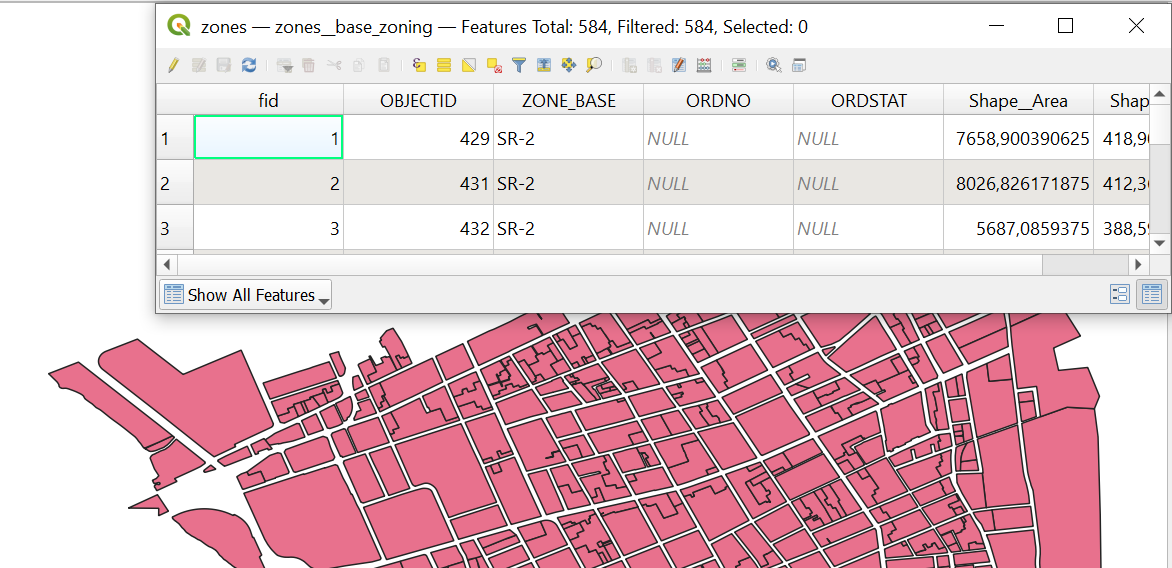

## **Step 3.1:** Load the information of the <em>yaml</em> file

<p>The <em>yaml</em> file is located in the <em>"example"/ "data" /</em>  - folder. The information in the file are converted into a python dictionary. </p>
<p><em>Note: Instead of loading a yaml file it is possible to create a python dictionary directly, built upon the structure seen below.</em></p>

In [44]:
#Let's read the yaml file with the required information 
#and set up the FIAT model for the two test cases. 

with open(Path(os.path.abspath("")) / "data" / "aggregation_zones" / "config_aggregation.yml", 'r') as file:
    config_aggregation = yaml.safe_load(file)

print(json.dumps(config_aggregation, indent=4, sort_keys=False))

{
    "cases": {
        "test1_single_aggregation": {
            "new_root": "./examples/data/aggregation_zones/aggregation_zones_test1",
            "configuration": {
                "setup_aggregation_areas": {
                    "aggregation_area_fn": "./examples/data/aggregation_zones/aggregation_zones/base_zones.gpkg",
                    "attribute_names": "ZONE_BASE",
                    "label_names": "Base_zones"
                }
            }
        },
        "test2_multiple_aggregation": {
            "new_root": "C:/Users/rautenba/hydromt_fiat/examples/data/aggregation_zones/aggregation_zones_test2",
            "configuration": {
                "setup_aggregation_areas": {
                    "aggregation_area_fn": [
                        "C:/Users/rautenba/hydromt_fiat/examples/data/aggregation_zones/aggregation_zones/base_zones.gpkg",
                        "C:/Users/rautenba/hydromt_fiat/examples/data/aggregation_zones/aggregation_zones/land_use.gpkg",
      

# **Step 4**: <strong>Define variables for the FIAT model</strong>

Set up the root path to the FIAT model and the logger settings to re-build your model:
- `root`: Directory path from where the neccessary data for the FIAT model is stored.  </p>
- `logger`: The logger variable defines the frequencies of log-entries during the initialisation of the model.</p>

In [45]:
# Set up Fiat Model
root = Path(os.path.abspath("")) / "data" / "aggregation_zones" / "fiat_model"

#If case exist
if Path(config_aggregation["cases"]["test1_single_aggregation"]["new_root"]).exists():
        shutil.rmtree(config_aggregation["cases"]["test1_single_aggregation"]["new_root"])

# Set up the logger
logger = setuplog("hydromt_fiat", log_level=10)

2023-10-23 19:37:44,713 - hydromt_fiat - log - INFO - HydroMT version: 0.8.0


# **Test case 1**: Run the FIAT model

It's time to run the model with the new configuration of the aggregation zones. The output will be 
stored in the prior defined <em>`"new_root"`</em> - directory. The output will be a **new <em>exposure.csv</em>**, in which each object is assigned **spatially** to an **aggregation zone**. 

In [46]:
#Start running the new model with the new exposure output 
fm = FiatModel(root=root, mode="r", logger=logger)
fm.read()
fm.build(write=False, opt=config_aggregation["cases"]["test1_single_aggregation"]["configuration"])
fm.set_root(config_aggregation["cases"]["test1_single_aggregation"]["new_root"])
fm.write()

2023-10-23 19:37:46,841 - hydromt_fiat - log - DEBUG - Appending log messages to file c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones\fiat_model\hydromt.log.
2023-10-23 19:37:46,842 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.2.1.dev0).
2023-10-23 19:37:46,845 - hydromt_fiat - fiat - INFO - Reading model data from c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones\fiat_model
2023-10-23 19:37:46,847 - hydromt_fiat - model_api - DEBUG - User defined config read from c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones\fiat_model\settings.toml
2023-10-23 19:37:46,848 - hydromt_fiat - fiat - INFO - Reading model table files.
2023-10-23 19:37:46,849 - hydromt_fiat - fiat - DEBUG - Reading vulnerability table c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones\fiat_model\vulnerability\vulnerability_curves.csv
2023-10-23 19:37:46,883 - hydromt_fiat - fiat - DEBUG - Reading exposure table c:\Users\rautenba\hy

DriverError: ./examples/data/aggregation_zones/aggregation_zones/base_zones.gpkg: No such file or directory

# **Test case 2**: Run the FIAT model

To run the test case 2, select it the configuration dictionary when re-running the model. Hence, the model will select the parameters of the second test case instead of the first and create spatial joints to **multiple** aggregation zones. 

<p>To run the second model, the <strong>logger</strong> must be set-up another time for the model to run through.</p>

In [32]:
#If case exist
if Path(config_aggregation["cases"]["test2_multiple_aggregation"]["new_root"]).exists():
        shutil.rmtree(config_aggregation["cases"]["test2_multiple_aggregation"]["new_root"])
        
# Set up the logger
logger = setuplog("hydromt_fiat", log_level=10)

2023-10-23 19:30:21,527 - hydromt_fiat - log - INFO - HydroMT version: 0.8.0


In [33]:
#Start running the new model with the new exposure output 
fm = FiatModel(root=root, mode="r", logger=logger)
fm.read()
fm.build(write=False, opt=config_aggregation["cases"]["test2_multiple_aggregation"]["configuration"])
fm.set_root(config_aggregation["cases"]["test2_multiple_aggregation"]["new_root"])
fm.write()

2023-10-23 19:30:23,424 - hydromt_fiat - log - DEBUG - Appending log messages to file c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones\fiat_model\hydromt.log.
2023-10-23 19:30:23,426 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.2.1.dev0).
2023-10-23 19:30:23,431 - hydromt_fiat - fiat - INFO - Reading model data from c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones\fiat_model
2023-10-23 19:30:23,435 - hydromt_fiat - model_api - DEBUG - User defined config read from c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones\fiat_model\settings.toml
2023-10-23 19:30:23,437 - hydromt_fiat - fiat - INFO - Reading model table files.
2023-10-23 19:30:23,439 - hydromt_fiat - fiat - DEBUG - Reading vulnerability table c:\Users\rautenba\hydromt_fiat\examples\data\aggregation_zones\fiat_model\vulnerability\vulnerability_curves.csv
2023-10-23 19:30:23,482 - hydromt_fiat - fiat - DEBUG - Reading exposure table c:\Users\rautenba\hy

# **Done!**  
Your **FIAT model** created a **spatial joint** with your original objects and the aggregation zones. <p>Let's have a look at the output!</p>

# **Result**: Test Case 1

Load the newly created *exposure.csv* file from the <em>/ "output" / "aggregation_zones_test1" /</em> - directory and the original exposure geopackage from the <em> "exposure" / "buildings.gpkg" </em>. Before the results can be displayed, we must merge the **exposure.csv** with the  **buildings.gpkg** via common *"Object ID"*. 

In [35]:
#Load *.csv into dataframe
df_single_aggregation = pd.read_csv(Path(os.path.abspath("")) / "data" / "aggregation_zones" / "aggregation_zones_test1" / "exposure" / "exposure.csv")

#Load original exposure geopackage into GeoDataFrame
new_exposure=gpd.read_file(Path(os.path.abspath("")) / "data" / "aggregation_zones" / "aggregation_zones_test1" / "exposure" / "buildings.gpkg")

#Merge dataframe with GeoDataFrame
merged_gdf = new_exposure.merge(df_single_aggregation, left_on='Object ID', right_on='Object ID', how='inner')

#Display base_zones aggregation zone
base_zones_map = merged_gdf.explore(column = 'Aggregation Label: Base_zones')
base_zones_map


# **Result**: Test Case 2

Load the newly created *exposure.csv* file from the <em>/ "output" / "aggregation_zones_test2" /</em> - directory and the original exposure geopackage from the <em> "exposure" / "buildings.gpkg" </em>.  Before the results can be displayed, we must merge the **exposure.csv** with the  **buildings.gpkg** via common *"Object ID"*. 

In [36]:
#Load *.csv into dataframe
df_multiple_aggregation = pd.read_csv(Path(os.path.abspath("")) / "data" / "aggregation_zones" / "aggregation_zones_test2" / "exposure" / "exposure.csv")

#Load original exposure geopackage into GeoDataFrame
new_exposure=gpd.read_file(Path(os.path.abspath("")) / "data" / "aggregation_zones" / "aggregation_zones_test2" / "exposure" / "buildings.gpkg")

#Merge dataframe with GeoDataFrame
merged_gdf_multiple = new_exposure.merge(df_multiple_aggregation, left_on='Object ID', right_on='Object ID', how='inner')

### **Base Zones**

In [37]:
#Display base_zones aggregation zone
base_zones_map = merged_gdf.explore(column = 'Aggregation Label: Base_zones')
base_zones_map

### **Land use**

In [ ]:
#Display land_use aggregation zone
land_use_map = merged_gdf_multiple.explore(column = 'Aggregation Label: Land_use')
land_use_map

### **Accomodation type**

In [ ]:
#Display accomodation_type aggregation zone
Accom_type_map = merged_gdf_multiple.explore(column = 'Aggregation Label: Accommodation_type')
Accom_type_map